In [1]:
start_url_list={"ねとらぼ":"https://nlab.itmedia.co.jp/",
               "business_insider":"https://www.businessinsider.jp/",
               "痛いニュース":"http://blog.livedoor.jp/dqnplus/",
                "アキバ総研":"https://akiba-souken.com/",
               "ZOZO":"https://zozo.jp/"}

In [2]:
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
import sys
from bs4 import BeautifulSoup

import networkx as nx

from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
start_url = start_url_list["ZOZO"]
# the page to bigin with

explore_num = 2
# how many times do you explore new links

In [4]:
fname = re.split('[/.]', start_url)
if fname[2]=="www":
    fname = fname[3]
else:
    fname = fname[2]
print(fname)

zozo


In [5]:
url_list = [start_url]
# list of the URL of all the pages. The components will be added.

link_list=[]
# list of lists [out_node, in_node]. The components will be added.

`link_explore`は、全てのリンク先を検索する関数。検索するURLの配列を引数にとる。  
`link_cruise`は、与えられたサイトのみへのリンク先を検索する関数。隣接行列を引数にとる。

In [6]:
def link_explore(link_list, url_list, now_url_list):
    # link_list: list of the URL of all the pages
    # url_list: list of lists [out_node, in_node]
    # next_url_list: list of the URL to explore in this function
    print(f"starting explorting {len(now_url_list)} pages")
    next_url_list=[]
    
    for url in now_url_list:
        
        try:
            with urlopen(url, timeout=10) as res:
                html = res.read().decode('utf-8', 'ignore')
                soup = BeautifulSoup(html, "html.parser")

        except:
            print("x", end="")
            continue
            #print(f"\n{url}")
            
        else:
            for a in soup.find_all("a"):
                link = a.get("href")

                if link!=None and len(link)>0:
                    if link[0]=="/":
                        link = url+link[1:]

                    if link[0:4] == "http":
                        if link[-1]=="/":
                            next_url_list.append(link)
                            link_list.append([url,link])
                            
            print("o", end="")
        
    next_url_list = list(set(next_url_list))
        
    url_list += next_url_list
    url_list = list(set(url_list))
        
    return link_list, url_list, next_url_list

In [7]:
def link_cruise(adj, url_list, now_url_list):
    # adj: adjacency matrix
    # next_url_list: list of the URL to explore in this function
    #print(f"starting cruising {len(now_url_list)} pages")
    next_url_list=[]
    
    for url in tqdm(now_url_list):
        
        try:
            with urlopen(url, timeout=10) as res:
                html = res.read().decode('utf-8', 'ignore')
                soup = BeautifulSoup(html, "html.parser")
                
        except:
            continue
            
        else:
            for a in soup.find_all("a"):
                link = a.get("href")

                if link!=None and len(link)>0:
                    if link[0]=="/":
                        link = url+link[1:]

                    if link[0:4] == "http":
                        if link[-1]=="/":
                            if link in url_list:
                                if adj[url_list.index(url),url_list.index(link)] == 0:
                                    next_url_list.append(link)
                                    adj[url_list.index(url),url_list.index(link)] = 1
            #print("o", end="")
        
    next_url_list = list(set(next_url_list))
        
    #print("")
    return adj, next_url_list

`explore_num`で与えられた回数だけリンクを辿る。リンク先のHTMLのdecodeに成功した場合に`o`、失敗した場合に`x`を表示する。

In [8]:
next_url_list = url_list
for i in range(explore_num):
    print(f"\nNo.{i+1} starting")
    link_list, url_list, next_url_list = link_explore(link_list, url_list, next_url_list)
    print(f"\nNo.{i+1} completed\n")


No.1 starting
starting explorting 1 pages
o
No.1 completed


No.2 starting
starting explorting 342 pages
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
No.2 completed



隣接行列を作成する。

In [9]:
adj = np.zeros((len(url_list),len(url_list)))

for link in tqdm(link_list):
    try:
        adj[url_list.index(link[0]),url_list.index(link[1])] = 1
    except:
        pass

In [10]:
print(f"the number of pages is {len(url_list)}")

the number of pages is 27379


In [11]:
print(f"the number of links is {np.sum(adj)} ({np.sum(adj)/len(url_list)/len(url_list)*100}%)")

the number of links is 34112.0 (0.004550635175195139%)


`explore_num`以降の検索は、すでに訪れたことのあるページに限定する。全てのページを訪れるまで検索を繰り返す。

In [12]:
while (len(next_url_list)>0):
    adj, next_url_list = link_cruise(adj, url_list, next_url_list)

In [44]:
print(f"the number of pages is {len(url_list)}")

the number of pages is 27379


In [45]:
print(f"the number of links is {np.sum(adj)} ({np.sum(adj)/len(url_list)/len(url_list)*100}%)")

the number of links is 34112.0 (0.004550635175195139%)


In [46]:
adj.shape

(27379, 27379)

# NetworkX

In [14]:
G = nx.DiGraph()

for i in tqdm(range(len(adj))):
    for j in range(len(adj)):
        if adj[i][j]==1:
            G.add_edge(i,j)
            
betweenness = nx.betweenness_centrality(G)
print("betweenness completed")
degree = nx.degree_centrality(G)
print("degree completed")
closeness = nx.closeness_centrality(G)
print("closeness completed")
pagerank = nx.pagerank(G)
print("pagerank completed")


nx.set_node_attributes(G, 'betweenness', betweenness)
nx.set_node_attributes(G, 'degree', degree)
nx.set_node_attributes(G, 'closeness', closeness)
nx.set_node_attributes(G, 'pagerank', pagerank)

pos = nx.spring_layout(G, k=0.6)
print("possition completed")


betweenness completed
degree completed
closeness completed
pagerank completed
possition completed


# Pagerank

マシンイプシロンを求める。

In [15]:
x = 1
while True:
    if x/2==0:
        print(x)
        break
    
    x=x/2

5e-324


誤差$10^{-10}$を許して、べき乗法を適用し、Pagerankを求める。

In [16]:
x = adj/adj.sum(axis=0)
rank = np.ones((len(adj),1))/len(adj)

for i in range(1000000):
    temp = np.dot(x, rank)
    
    if np.linalg.norm(rank-temp)<1e-10:
        print(f"finished after {i} times")
        break
        
    rank = temp
    
rank = rank.flatten()

finished after 33 times


In [17]:
df = pd.DataFrame({"ID": range(len(url_list)), "URL": url_list, "Pagerank": rank})

同じトップページを持つサイトを同じカテゴリとする。カテゴリ別のページ数が全体の$10\%$以上を占めるもののみ記憶する。

In [18]:
df["category"] = df["URL"].apply(lambda s: s[s.index(":")+3:s.index("/", 8)])

In [19]:
category_count = list(df.groupby("category").count()["ID"])
df["category"] = df["category"].apply(lambda x: "others" if df.groupby("category").count().loc[x,"ID"]<0.1*len(adj) else x)

df.loc[df['URL'] ==start_url, 'category'] = "start_page"

In [20]:
df[["URL","Pagerank"]].sort_values('Pagerank', ascending=False).head(10)

,URL,Pagerank
2167,https://zozo.jp/,0.148092
7043,https://zozo.jp/brand/,0.064747
6492,https://zozo.jp/shop/,0.016911
2612,https://zozo.jp/category/,0.002438
4618,https://zozo.jp/category/jacket-outerwear/no-collar-jacket/,0.001163
2803,https://zozo.jp/category/jacket-outerwear/jacket/,0.001163
27308,https://zozo.jp/category/jacket-outerwear/riders-jacket/,0.001163
20142,https://zozo.jp/category/jacket-outerwear/pea-coat/,0.001163
19707,https://zozo.jp/category/jacket-outerwear/ma1/,0.001163
801,https://zozo.jp/category/jacket-outerwear/mods-coat/,0.001163


# 次数中心性
各ノードの出次数と入次数の合計である。

In [21]:
df["degree_centrality"] = df.index.values.tolist()
df["degree_centrality"] = df["degree_centrality"].apply(lambda x: adj[x,:].sum() + adj[:,x].sum())

In [22]:
df[["URL","degree_centrality"]].sort_values('degree_centrality', ascending=False).head(10)

,URL,degree_centrality
7043,https://zozo.jp/brand/,34509.0
6492,https://zozo.jp/shop/,28995.0
2167,https://zozo.jp/,27562.0
2612,https://zozo.jp/category/,27327.0
21862,https://corp.zozo.com/ir/,27246.0
15378,https://wear.jp/,27240.0
3828,https://zozo.jp/fashionnews/,27108.0
23684,https://zozo.jp/coordinate/,27085.0
19611,https://zozo.jp/welcome/,27084.0
11315,https://corp.zozo.com/about/profile/,27073.0


# 近接中心性
各ノードから他の全てのノードへの平均最短経路長の逆数である。

In [23]:
df["closeness_centrality"] = df["ID"].map(closeness)

In [24]:
df[["URL","closeness_centrality"]].sort_values('closeness_centrality', ascending=False).head(10)

,URL,closeness_centrality
2167,https://zozo.jp/,0.503133
7043,https://zozo.jp/brand/,0.426828
6492,https://zozo.jp/shop/,0.393040
2612,https://zozo.jp/category/,0.383849
9413,https://zozo.jp/category/jacket-outerwear/denim-jacket/,0.383059
1332,https://zozo.jp/category/jacket-outerwear/tailored-jacket/,0.383059
5336,https://zozo.jp/category/jacket-outerwear/coveralls/,0.383059
21234,https://zozo.jp/category/jacket-outerwear/trench-coat/,0.383059
18113,https://zozo.jp/category/jacket-outerwear/chester-coat/,0.383059
12081,https://zozo.jp/category/jacket-outerwear/stand-collar-coat/,0.383059


# 媒介中心性
他の全てのノードから到達可能なノードへの最短経路が、各ノードを通る回数を割合である。

In [25]:
df["betweenness_centrality"] = df["ID"].map(betweenness)

In [26]:
df[["URL","betweenness_centrality"]].sort_values('betweenness_centrality', ascending=False).head(10)

,URL,betweenness_centrality
2167,https://zozo.jp/,0.623272
7043,https://zozo.jp/brand/,0.271071
6492,https://zozo.jp/shop/,0.070765
2612,https://zozo.jp/category/,0.010172
15378,https://wear.jp/,0.005630
21862,https://corp.zozo.com/ir/,0.002454
16238,https://zozo.jp/category/jacket-outerwear/mountain-parker/,0.002398
9233,https://zozo.jp/category/jacket-outerwear/nylon-jacket/,0.002398
19707,https://zozo.jp/category/jacket-outerwear/ma1/,0.002398
21234,https://zozo.jp/category/jacket-outerwear/trench-coat/,0.002398


# 散布図

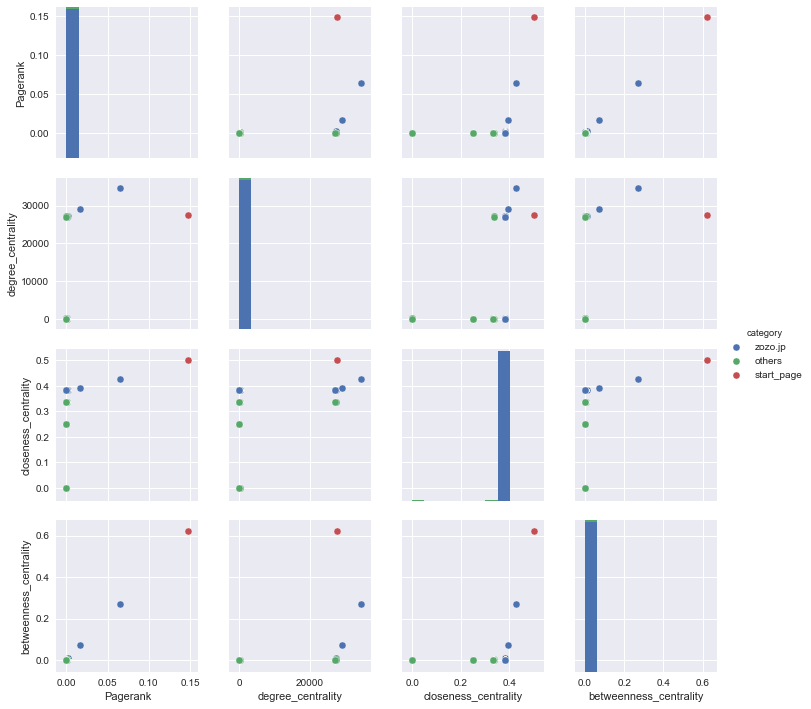

In [27]:
sns.pairplot(df.drop("ID", axis=1), hue='category')
plt.savefig(f'{fname}_pairplot.png')

# 強連結成分分解

In [28]:
strong_connection = sorted(nx.strongly_connected_components(G), key=lambda x: len(x), reverse=True)

# 可視化

In [29]:
def draw_char_graph(G, pos, title, node_type):
    plt.figure(figsize=(15, 15))

    nx.draw_networkx_edges(G,
                           pos=pos,
                           edge_color="gray",
                           edge_cmap=plt.cm.Greys,
                           edge_vmin=-3e4,
                           width=0.3,
                           alpha=0.2,
                           arrows=False)
    
    if node_type=="centrality":
        node1=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="blue",
                                     alpha=0.8,
                                     node_size=[ d["closeness"]*300 for (n,d) in G.nodes(data=True)])

        node2=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="green",
                                     alpha=0.8,
                                     node_size=[ d["degree"]*2000 for (n,d) in G.nodes(data=True)])

        node3=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="yellow",
                                     alpha=0.8,
                                     node_size=[ d["betweenness"]*5000 for (n,d) in G.nodes(data=True)])

        node4=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="red",
                                     alpha=0.8,
                                     node_size=[ d["pagerank"]*10000 for (n,d) in G.nodes(data=True)])
        
        plt.legend([node1, node2, node3,node4], ["closeness", "degree","betweenness","pagerank"],markerscale=1,fontsize=18)
        plt.title(f"centrality: {start_url}\n {nx.number_of_nodes(G)} nodes,{nx.number_of_edges(G)} edges",fontsize=25)
        
    elif node_type=="simple":
        nx.draw_networkx_nodes(G,
                               pos=pos,
                               node_color="blue",
                               node_size=5)
        plt.title(f"{start_url}\n {nx.number_of_nodes(G)} nodes,{nx.number_of_edges(G)} edges",fontsize=25)
        
    elif node_type=="strong_connection":
        nx.draw_networkx_nodes(G,
                               pos=pos,
                               node_color="black",
                               node_size=10)
        
        node1=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="blue",
                                     nodelist=strong_connection[0],
                                     node_size=30)
        
        node2=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="yellow",
                                     nodelist=strong_connection[1],
                                     node_size=30)
        
        node3=nx.draw_networkx_nodes(G,
                                     pos=pos,
                                     node_color="red",
                                     nodelist=strong_connection[2],
                                     node_size=30)
        
        plt.title(f"strongly connected nodes: {title}\n {nx.number_of_nodes(G)} nodes,{nx.number_of_edges(G)} edges",fontsize=25)
        plt.legend([node1, node2, node3], [f"elements: {len(strong_connection[0])} ({round(len(strong_connection[0])/nx.number_of_nodes(G)*100,2)}%)",
                                           f"elements: {len(strong_connection[1])} ({round(len(strong_connection[1])/nx.number_of_nodes(G)*100,2)}%)",
                                           f"elements: {len(strong_connection[2])} ({round(len(strong_connection[2])/nx.number_of_nodes(G)*100,2)}%)"],markerscale=1,fontsize=18)

    plt.savefig(f"{title}_graph_{node_type}", dpi=300)
    plt.axis('off')
    plt.show()

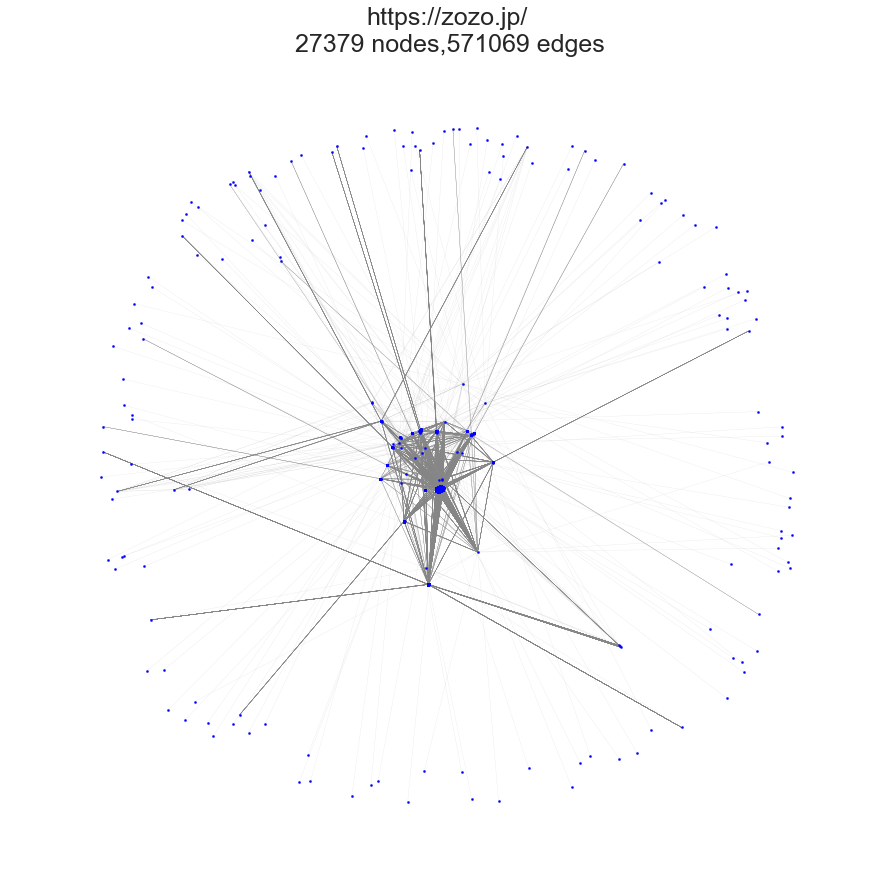

In [50]:
draw_char_graph(G, pos, fname, node_type="simple")

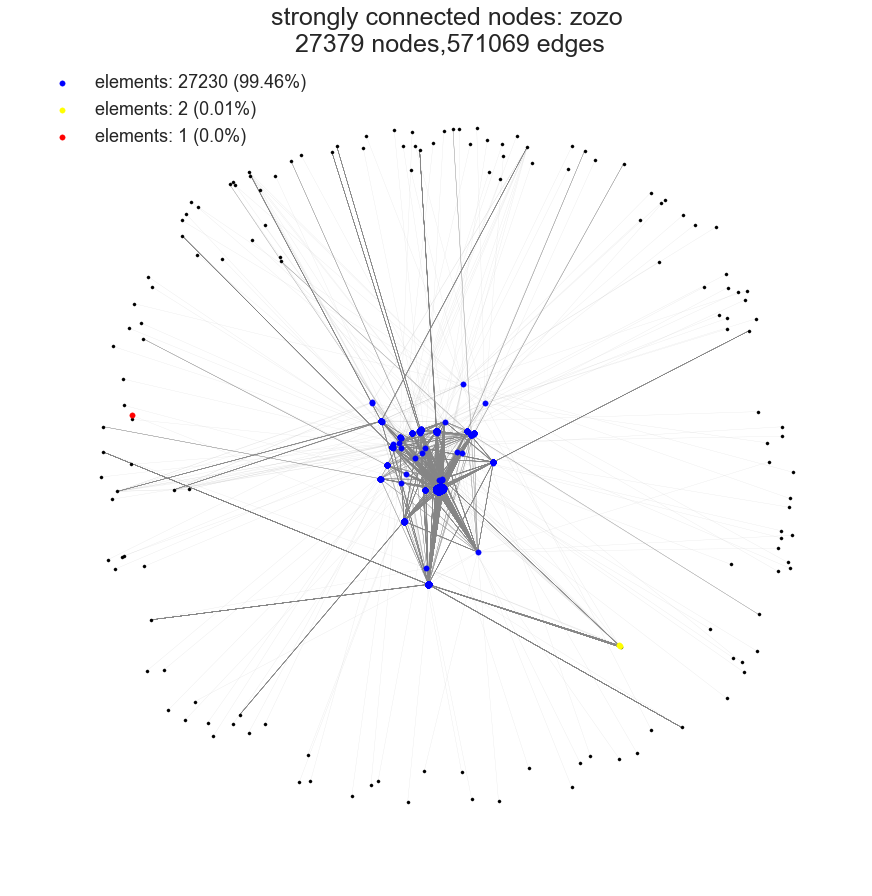

In [51]:
draw_char_graph(G, pos, fname, node_type="strong_connection")

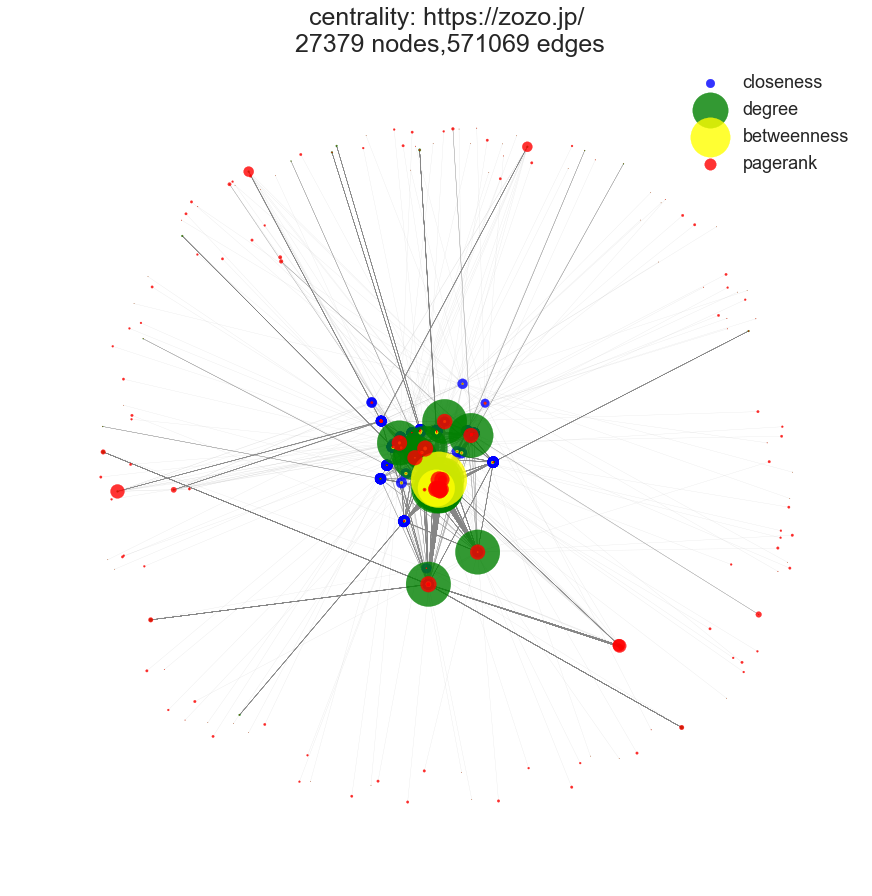

In [52]:
# betweenness, degree, closeness, pagerank
draw_char_graph(G, pos, fname, node_type="centrality")

# 中心性ランキングDataFrame

In [33]:
from scipy import stats

df = df.assign(Pagerank_rank=len(df)-stats.mstats.rankdata(df["Pagerank"])+1)
df = df.assign(degree_centrality_rank=len(df)-stats.mstats.rankdata(df["degree_centrality"])+1)
df = df.assign(closeness_centrality_rank=len(df)-stats.mstats.rankdata(df["closeness_centrality"])+1)
df = df.assign(betweenness_centrality_rank=len(df)-stats.mstats.rankdata(df["betweenness_centrality"])+1)

In [53]:
df_important = df[(df["Pagerank_rank"]<=10) | (df["degree_centrality_rank"]<=10) | (df["closeness_centrality_rank"]<=10) | (df["betweenness_centrality_rank"]<=10)]
df_important = df_important[["URL", "Pagerank_rank", "degree_centrality_rank", "closeness_centrality_rank", "betweenness_centrality_rank"]]

In [35]:
df_important = df_important.sort_values(["Pagerank_rank", "degree_centrality_rank", "closeness_centrality_rank", "betweenness_centrality_rank"])
df_important = df_important.ix[:,df_important.columns.values.tolist()[1:]+["URL"]]
df_important.to_csv(f"./{fname}.csv")

In [36]:
df_important

,Pagerank_rank,degree_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,URL
2167,1.0,3.0,1.0,1.0,https://zozo.jp/
7043,2.0,1.0,2.0,2.0,https://zozo.jp/brand/
6492,3.0,2.0,3.0,3.0,https://zozo.jp/shop/
2612,4.0,4.0,4.0,4.0,https://zozo.jp/category/
4618,5.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/no-collar-jacket/
801,8.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/mods-coat/
2803,8.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/jacket/
19707,8.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/ma1/
20142,8.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/pea-coat/
27308,8.0,39.5,14.5,16.5,https://zozo.jp/category/jacket-outerwear/riders-jacket/
